In [15]:
%load_ext autoreload
%autoreload

# !nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt
%matplotlib notebook
import MEAutility as mu

import json
import numpy
import time
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define extracellular electrodes

In [16]:
mea_positions = np.zeros((5, 3))
mea_positions[:, 2] = 20
mea_positions[:, 1] = np.linspace(0, 900, 5)
probe = mu.return_mea(info={'pos': mea_positions, 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')

## Setup protocols, fitness, and evaluator

In [45]:
import l5pc_model
import l5pc_evaluator

feature_set = "extra" # 'soma'/'bap'

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

if feature_set == "extra":
    fitness_protocols = l5pc_evaluator.define_protocols(electrode) 
else:
    fitness_protocols = l5pc_evaluator.define_protocols() 

fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols, feature_set=feature_set, 
                                                              probe=probe)

if feature_set == "extra":
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)
else:
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True, electrode=electrode)

evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [46]:
extrafeat = fitness_calculator.objectives[-1].features[0]

In [47]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [48]:
t_start = time.time()
LFPy_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                         param_values=release_params)
t_end = time.time()
print(t_end-t_start)

/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib

20.65457510948181


In [52]:
feat, mean_wf = extrafeat.calculate_feature(LFPy_responses, return_waveforms=True)

interpolate
filter enabled


In [54]:
tr, pk = bpopt.ephys.extra_features_utils._get_trough_and_peak_idx(mean_wf, False)

<IPython.core.display.Javascript object>


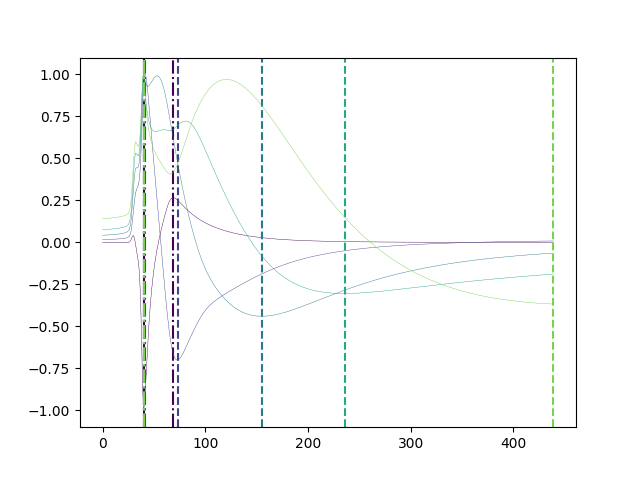

In [55]:
plt.figure()
cmap = plt.get_cmap('viridis')
idxs = range(0, 10)
for i, mw in enumerate(mean_wf):
    if i in idxs:
        color = cmap(i/len(mean_wf))
        plt.plot(mw / np.max(np.abs(mw)), color=color, lw=0.3)
        plt.axvline(tr[i], ls='--', color=color)
        plt.axvline(pk[i], ls='-.', color=color)

In [56]:
mean_wf_norm = mean_wf / np.max(np.abs(mean_wf), 1, keepdims=True)

<IPython.core.display.Javascript object>


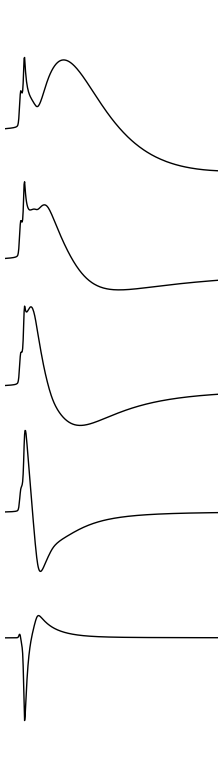

In [57]:
mu.plot_mea_recording(mean_wf_norm, probe)

## Optimization

In [60]:
offspring_size = 20
max_ngen = 20

In [ ]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=offspring_size) 
final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename='checkpoints/checkpoint.pkl')

<IPython.core.display.Javascript object>


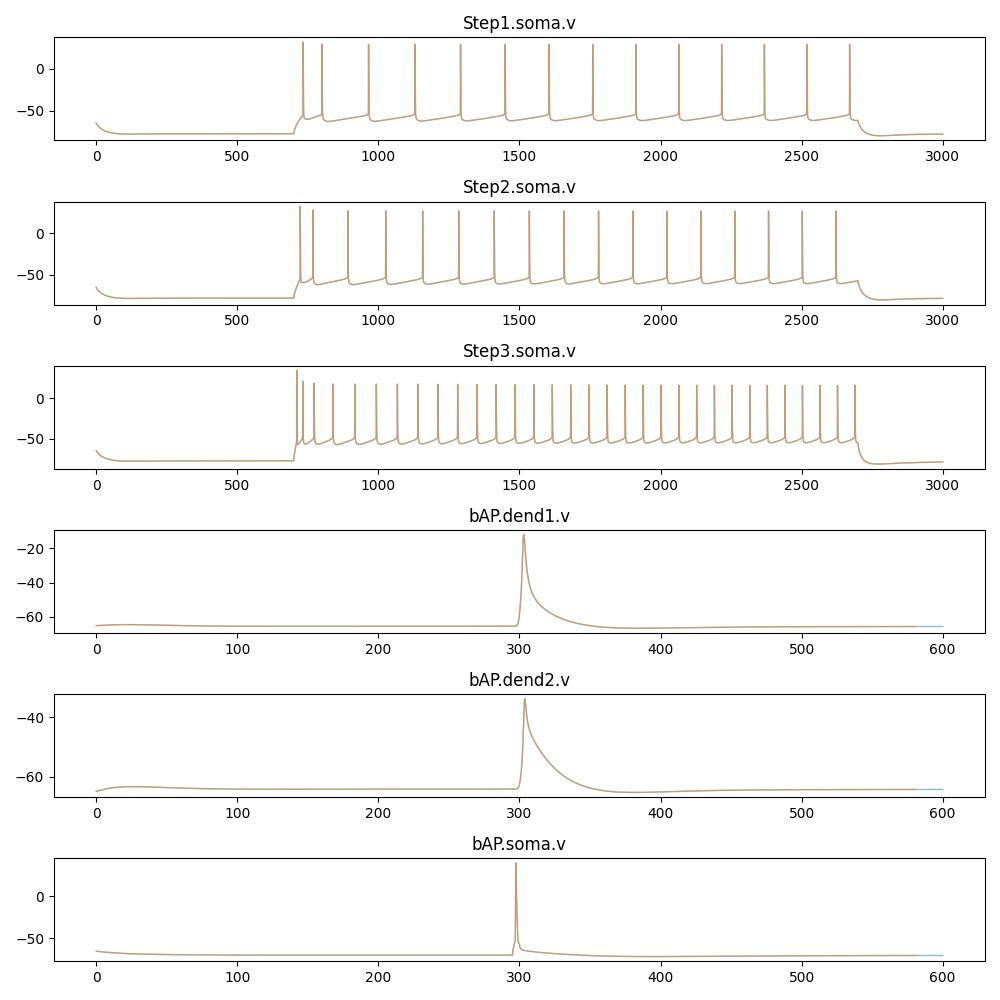

bAP.soma.v 1.0035285431524778e-08
580.5274986307397 600.0
bAP.dend1.v 1.0035285431524778e-08
580.5274986307397 600.0
bAP.dend2.v 1.0035285431524778e-08
580.5274986307397 600.0
Step3.soma.v 40.244803218433255
2999.9999999999336 3000.0000000000337
Step2.soma.v 24.537492546279005
2999.9999999999336 3000.0000000000337
Step1.soma.v 56.72957047144788
2999.9999999999336 3000.0000000000337


In [58]:
# import pickle
# original_responses = pickle.load(open("responses.pkl", "rb"))

# fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
# for index, (resp_name, response) in enumerate(sorted(original_responses.items())):
#     axes[index].plot(response['time'], response['voltage'], label=resp_name, lw=1.0, alpha=0.5)
#     axes[index].plot(LFPy_responses[resp_name]['time'], LFPy_responses[resp_name]['voltage'], label=resp_name, lw=1.0, alpha=0.5)
#     axes[index].set_title(resp_name)
# fig.tight_layout()

# for resp_name in original_responses:
#     end = numpy.min([len(original_responses[resp_name]['time']), len(LFPy_responses[resp_name]['time'])])
#     _ = numpy.sum(numpy.abs(original_responses[resp_name]['time'][:end]-LFPy_responses[resp_name]['time'][:end]))
#     print(resp_name, _/end)
#     print(LFPy_responses[resp_name]['time'].iloc[-1], original_responses[resp_name]['time'].iloc[-1])
# fig.show()

<IPython.core.display.Javascript object>


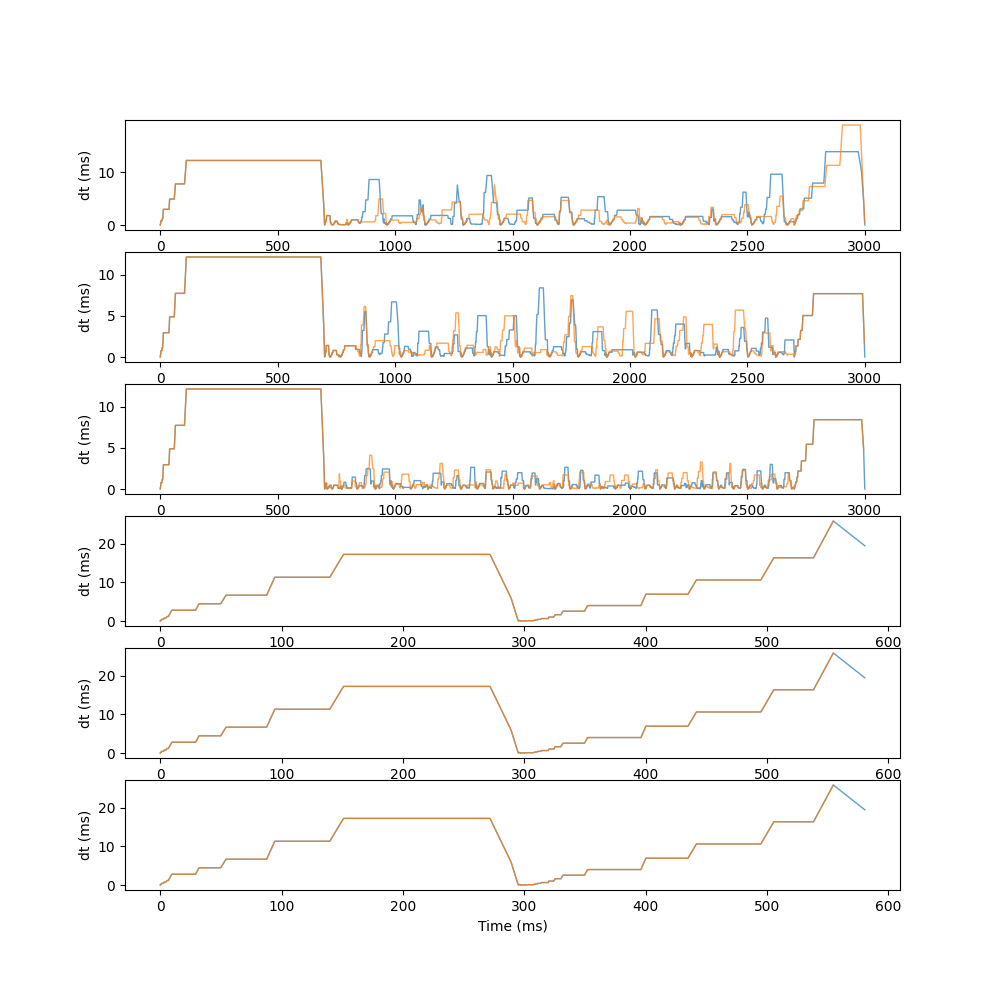

In [59]:
# fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
# for index, (resp_name, response) in enumerate(sorted(original_responses.items())): 
        
#         diff = numpy.diff(original_responses[resp_name]['time'])
#         axes[index].plot(original_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
#         diff = numpy.diff(LFPy_responses[resp_name]['time'])
#         axes[index].plot(LFPy_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
#         axes[index].set_xlabel("Time (ms)")
#         axes[index].set_ylabel("dt (ms)")